In [1]:
import locale
import requests
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Replace with your actual SQL login details
server = 'YOUR_SERVER_NAME'
database = 'YOUR_DATABASE_NAME'
username = 'python'
password = '1234'

# Replace YOUR_API_KEY with your actual API key
api_key = "YOUR_API_KEY"

# Set the locale to your desired currency format (e.g., USD in this case)
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')  # Replace 'en_US.UTF-8' with your desired locale

'en_US.UTF-8'

**************************************************************************************************

Establishes connection to SQL Server and then performs stored SQL procedure to retrieve dataset. Then converts data into dataframe

In [20]:
# Create a connection string using SQLAlchemy format
conn_str = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=SQL+Server'

# Create an SQLAlchemy engine to connect to the database
engine = create_engine(conn_str)

# Define the SQL query to retrieve all records from the table
sql_query = 'EXEC dbo.spDelivery_Data_GetAll'

# Use pandas to read data from the SQL query into a DataFrame using the SQLAlchemy engine
df = pd.read_sql_query(sql_query, engine)

# Close the SQLAlchemy engine
engine.dispose()

df

,PrimaryKey,Company_ID,Company_Name,Origin_Coordinates,Cost_Per_Minute,Estimated_Trips_Per_Month,Date,Destination_Coordinates
0,1,1,QuickShip,"36.151563, -115.324362",25.77,39,2023-06-01,"35.948026, -115.151723"
1,2,1,QuickShip,"36.151563, -115.324362",25.77,87,2023-07-01,"35.948026, -115.151723"
2,3,1,QuickShip,"36.151563, -115.324362",25.77,17,2023-08-01,"35.948026, -115.151723"
3,4,1,QuickShip,"36.151563, -115.324362",25.77,37,2023-09-01,"35.948026, -115.151723"
4,5,1,QuickShip,"36.151563, -115.324362",25.77,84,2023-10-01,"35.948026, -115.151723"
...,...,...,...,...,...,...,...,...
65,66,5,HyperHaulers,"35.938428, -115.083748",66.87,35,2024-03-01,"36.358144, -115.220407"
66,67,5,HyperHaulers,"35.938428, -115.083748",66.87,17,2024-04-01,"36.358144, -115.220407"
67,68,5,HyperHaulers,"35.938428, -115.083748",66.87,38,2024-05-01,"36.358144, -115.220407"
68,69,5,HyperHaulers,"35.938428, -115.083748",66.87,65,2024-06-01,"36.358144, -115.220407"


**************************************************************************************************

Creates a list of all unique origin to destination coordinates (Origin Coordinates|Destination Coordinates)

In [21]:
# Creates List of Origin coordinates: [longitude, latitude]
origin_coordinates_list = df['Origin_Coordinates'].unique().tolist()

# Creates List of Destination coordinates: [longitude, latitude]
destination = df['Destination_Coordinates'].unique().tolist()

# Concatenate the two columns and extract unique values
combined_coordinates = df['Origin_Coordinates'] + '|' + df['Destination_Coordinates']
unique_combined_coordinates = combined_coordinates.unique()
print(unique_combined_coordinates)


['36.151563, -115.324362|35.948026, -115.151723'
 '36.262438, -115.300015|36.146000, -115.018187'
 '35.987830, -115.134663|36.184620, -115.372731'
 '36.134497, -115.180412|35.948026, -115.151723'
 '35.938428, -115.083748|36.358144, -115.220407']


**************************************************************************************************

Definition instructing Python on how to communicate and interface with the openrouteservice.org API

In [22]:
# Creates definition that will retrieve travel time data from "Open Route Service" 
def get_travel_time(api_key, coordinates, profile='driving-car'):
    base_url = "https://api.openrouteservice.org/v2/matrix/driving-car"

    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    # Switch latitude and longitude positions in the coordinates
    coordinates = [[coord[1], coord[0]] for coord in coordinates]
    
    params = {
        "locations": coordinates,
        "profile": profile
    }

    response = requests.post(base_url, json=params, headers=headers)
    data = response.json()

    #print("API Response:", data)  # Print the full API response for debugging

    if 'durations' in data and len(data['durations']) > 0:
        travel_time = data['durations'][0][1]  # Travel time from the first to the second location in seconds
        return travel_time
    else:
        return None


**************************************************************************************************

This code retrieves travel times from each company location from openrouteservice.org API using origin-destination coordinates

In [23]:
if __name__ == "__main__":

    # Create an empty dictionary to store the travel times for each unique combined coordinate
    travel_times_dict = {}

    for i, coordinates in enumerate(unique_combined_coordinates):
        # Split the combined coordinates into origin and destination coordinates
        origin_coord, destination_coord = coordinates.split('|')
        origin_coord = list(map(float, origin_coord.split(',')))
        destination_coord = list(map(float, destination_coord.split(',')))

        # Get travel time for each origin-destination pair
        travel_time = get_travel_time(api_key, [origin_coord, destination_coord])

        if travel_time is not None:
            # Store the travel time in the dictionary with the combined coordinates as the key
            travel_times_dict[coordinates] = travel_time
            print(f"Travel time from Origin {i+1} to Destination: {travel_time} seconds")
        else:
            print(f"Error: Unable to retrieve travel time from Origin {i+1} to Destination.")

Travel time from Origin 1 to Destination: 1928.13 seconds
Travel time from Origin 2 to Destination: 2004.07 seconds
Travel time from Origin 3 to Destination: 2275.46 seconds
Travel time from Origin 4 to Destination: 1403.49 seconds
Travel time from Origin 5 to Destination: 3780.42 seconds


**************************************************************************************************

Calculates the total travel time and associated costs based on estimated trips per month and cost per minute. Then creates columns detailing total travel time in minutes and total cost values

In [25]:
# Use the map function to assign the travel times to the appropriate rows in the DataFrame
df['Estimated_Travel_Time'] = df['Origin_Coordinates'] + '|' + df['Destination_Coordinates']
df['Estimated_Travel_Time'] = df['Estimated_Travel_Time'].map(travel_times_dict)

# Calculate the total time for each row (in seconds) by multiplying estimated travel time and estimated number of trips
df['Total_Time_In_Minutes'] = df['Estimated_Travel_Time'] * df['Estimated_Trips_Per_Month']

# Convert 'Total_Time_In_Minutes' from seconds to minutes
df['Total_Time_In_Minutes'] = df['Total_Time_In_Minutes'] / 60

# Create 'Total_Cost' column by multiplying total time (in minutes) with estimated cost per minute
df['Total_Cost'] = df['Total_Time_In_Minutes'] * df['Cost_Per_Minute']

# Convert the 'Total_Cost' column to numeric
df['Total_Cost'] = pd.to_numeric(df['Total_Cost'], errors='coerce')

# Format the 'Total_Cost' column to display monetary values
df['Total_Cost'] = df['Total_Cost'].apply(lambda x: locale.currency(x, grouping=True) if pd.notnull(x) else None)
df

,PrimaryKey,Company_ID,Company_Name,Origin_Coordinates,Cost_Per_Minute,Estimated_Trips_Per_Month,Date,Destination_Coordinates,Estimated_Travel_Time,Total_Time_In_Minutes,Total_Cost
0,1,1,QuickShip,"36.151563, -115.324362",25.77,39,2023-06-01,"35.948026, -115.151723",1928.13,1253.2845,"$32,297.14"
1,2,1,QuickShip,"36.151563, -115.324362",25.77,87,2023-07-01,"35.948026, -115.151723",1928.13,2795.7885,"$72,047.47"
2,3,1,QuickShip,"36.151563, -115.324362",25.77,17,2023-08-01,"35.948026, -115.151723",1928.13,546.3035,"$14,078.24"
3,4,1,QuickShip,"36.151563, -115.324362",25.77,37,2023-09-01,"35.948026, -115.151723",1928.13,1189.0135,"$30,640.88"
4,5,1,QuickShip,"36.151563, -115.324362",25.77,84,2023-10-01,"35.948026, -115.151723",1928.13,2699.3820,"$69,563.07"
...,...,...,...,...,...,...,...,...,...,...,...
65,66,5,HyperHaulers,"35.938428, -115.083748",66.87,35,2024-03-01,"36.358144, -115.220407",3780.42,2205.2450,"$147,464.73"
66,67,5,HyperHaulers,"35.938428, -115.083748",66.87,17,2024-04-01,"36.358144, -115.220407",3780.42,1071.1190,"$71,625.73"
67,68,5,HyperHaulers,"35.938428, -115.083748",66.87,38,2024-05-01,"36.358144, -115.220407",3780.42,2394.2660,"$160,104.57"
68,69,5,HyperHaulers,"35.938428, -115.083748",66.87,65,2024-06-01,"36.358144, -115.220407",3780.42,4095.4550,"$273,863.08"


**************************************************************************************************

Creates visualizations of each company's projected costs over the next year

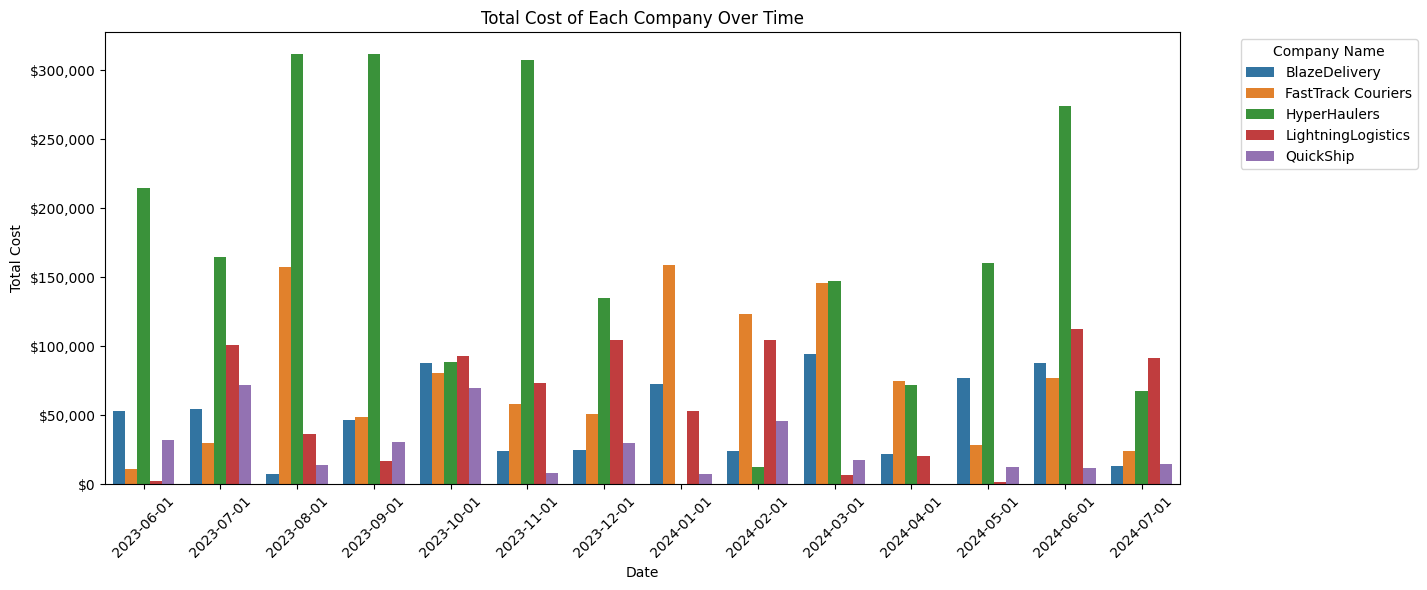

In [26]:
# Make a copy of the DataFrame to avoid modifying the original data
df_visual = df.copy()

# Convert the 'Total_Cost' column to numeric
df_visual['Total_Cost'] = pd.to_numeric(df_visual['Total_Cost'].str.replace('[\$,]', '', regex=True), errors='coerce')

# Group by 'Company_Name' and 'Date' to get Total_Cost for each company over time
cost_by_company_and_month = df_visual.groupby(['Company_Name', 'Date'])['Total_Cost'].sum().reset_index()

# Create the bar plot (vertical bars)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Date', y='Total_Cost', hue='Company_Name', data=cost_by_company_and_month)
plt.title('Total Cost of Each Company Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis labels to include the '$' sign
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.legend(title='Company Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**************************************************************************************************

Creates bar graph comparing the total cost for each company

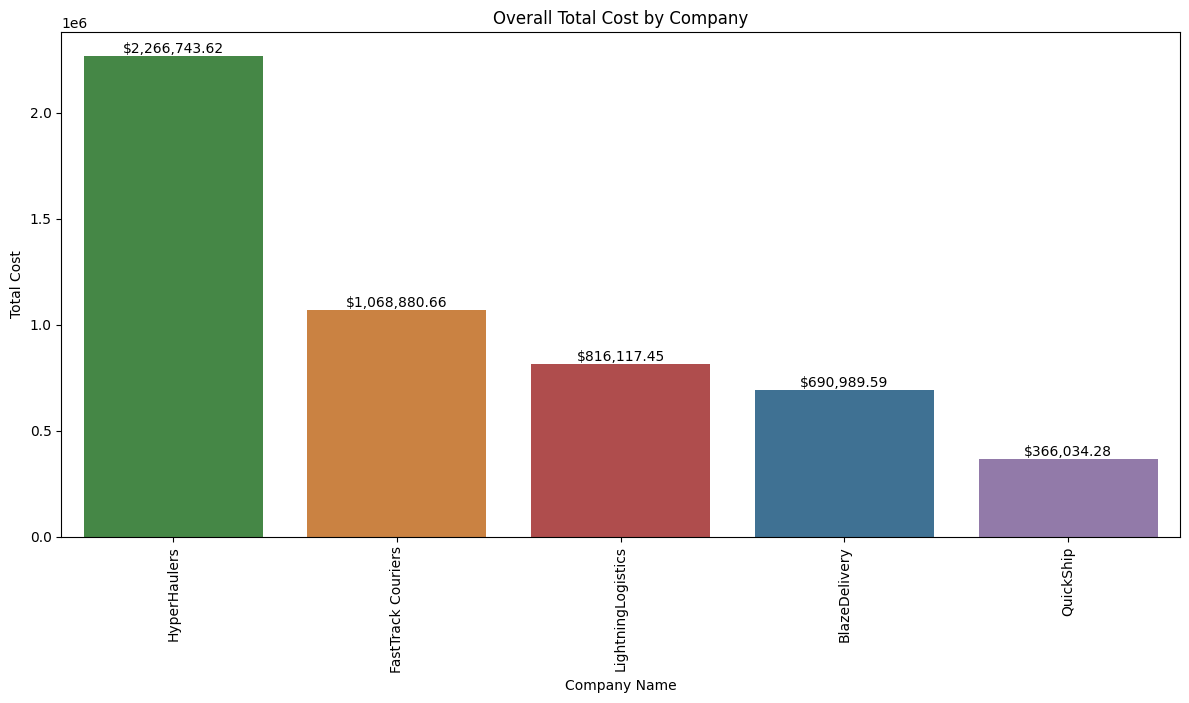

In [29]:
# Group by 'Company_Name' to get the overall Total_Cost for each company
cost_by_company = df_visual.groupby('Company_Name')['Total_Cost'].sum().reset_index()

# Sort the DataFrame in descending order based on Total_Cost
cost_by_company = cost_by_company.sort_values(by='Total_Cost', ascending=False)

# Define a list of custom colors for each company (replace with your desired colors)
custom_colors = ['#3a923b', '#e1812b', '#bf3d3d', '#3174a1', '#9272b1']

# Create the bar plot (vertical bars) with custom colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Company_Name', y='Total_Cost', data=cost_by_company, palette=custom_colors)
plt.title('Overall Total Cost by Company')
plt.xlabel('Company Name')
plt.ylabel('Total Cost')

# Display dollar amounts inside the bars
for idx, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    cost = cost_by_company.iloc[idx]['Total_Cost']
    ax.annotate(locale.currency(cost, grouping=True), (x + width / 2, y + height), ha='center', va='bottom')

plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


**************************************************************************************************

Shows the total number of trips each company is expected to do over the course of the next year

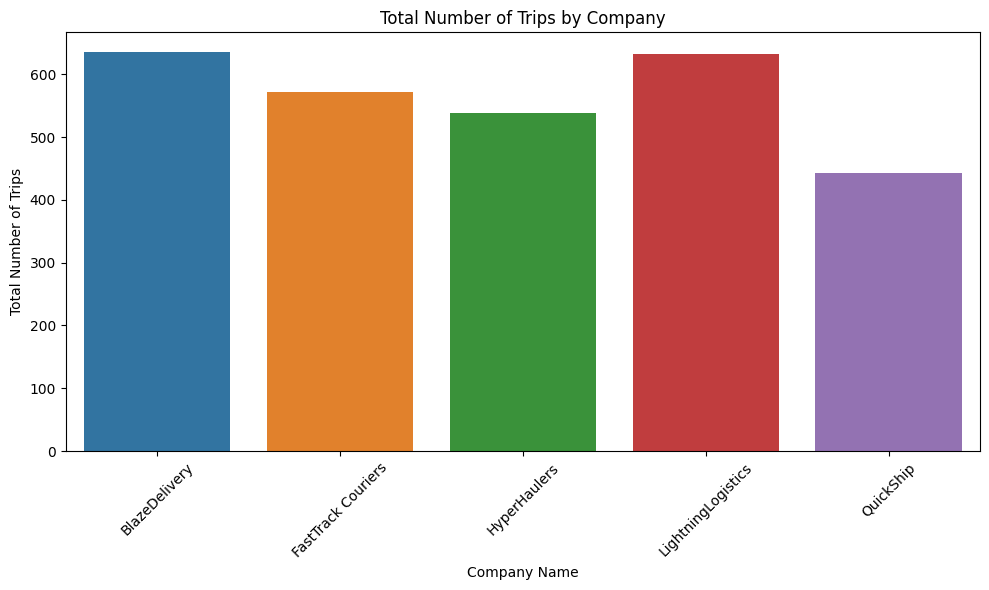

In [28]:
# Group by 'Company_Name' to get the total number of trips for each company
trips_by_company = df.groupby('Company_Name')['Estimated_Trips_Per_Month'].sum().reset_index()

# Create the bar plot (vertical bars)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Company_Name', y='Estimated_Trips_Per_Month', data=trips_by_company)
plt.title('Total Number of Trips by Company')
plt.xlabel('Company Name')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**************************************************************************************************

Shows the total amount of travel time each company is expected to make over the course of the next year

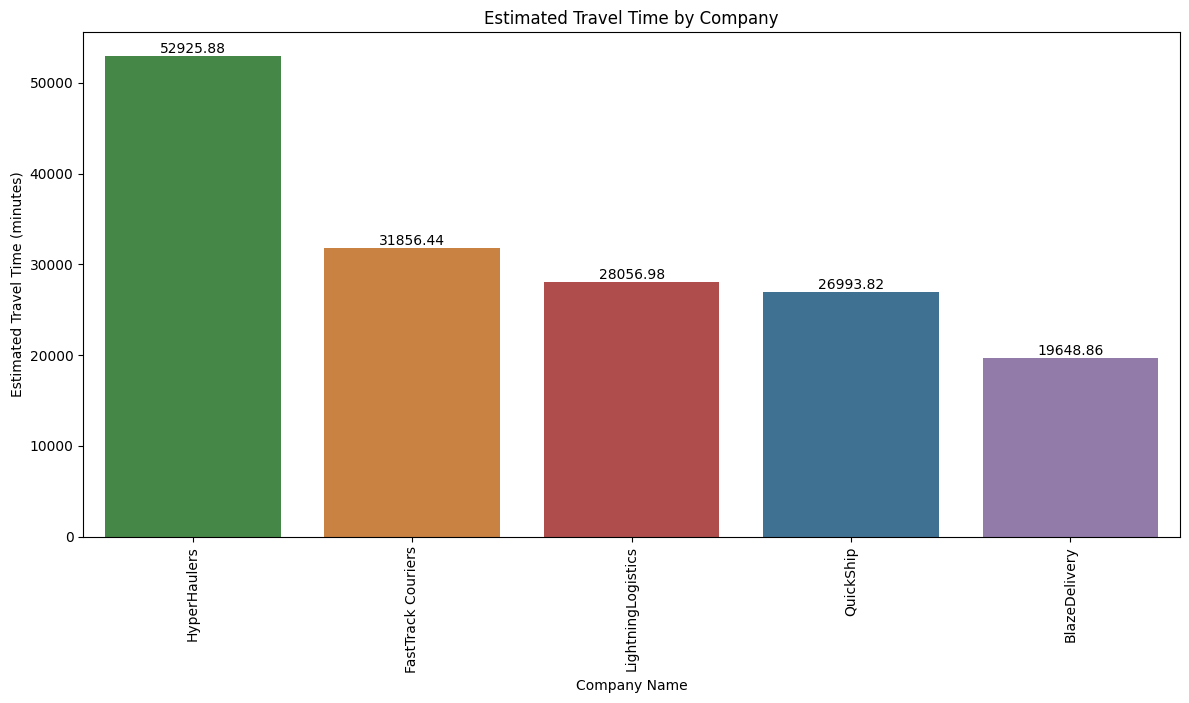

In [31]:
# Group by 'Company_Name' to get the overall Estimated_Travel_Time for each company
travel_time_by_company = df_visual.groupby('Company_Name')['Estimated_Travel_Time'].sum().reset_index()

# Sort the DataFrame in descending order based on Estimated_Travel_Time
travel_time_by_company = travel_time_by_company.sort_values(by='Estimated_Travel_Time', ascending=False)

# Define a list of custom colors for each company (replace with your desired colors)
custom_colors = ['#3a923b', '#e1812b', '#bf3d3d', '#3174a1', '#9272b1']

# Create the bar plot (vertical bars) with custom colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Company_Name', y='Estimated_Travel_Time', data=travel_time_by_company, palette=custom_colors)
plt.title('Estimated Travel Time by Company')
plt.xlabel('Company Name')
plt.ylabel('Estimated Travel Time (minutes)')

# Display travel time values inside the bars
for idx, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    travel_time = travel_time_by_company.iloc[idx]['Estimated_Travel_Time']
    ax.annotate(f'{travel_time:.2f}', (x + width / 2, y + height), ha='center', va='bottom')

plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()

**************************************************************************************************

This will drop all columns we don't want to move back into SQL

In [33]:
# Drop all columns except PrimaryKey, Estimated_Travel_Time, Total_Time_In_Minutes, and Total_Cost
columns_to_keep = ['PrimaryKey', 'Estimated_Travel_Time', 'Total_Time_In_Minutes', 'Total_Cost']
df = df[columns_to_keep]
df

,PrimaryKey,Estimated_Travel_Time,Total_Time_In_Minutes,Total_Cost
0,1,1928.13,1253.2845,"$32,297.14"
1,2,1928.13,2795.7885,"$72,047.47"
2,3,1928.13,546.3035,"$14,078.24"
3,4,1928.13,1189.0135,"$30,640.88"
4,5,1928.13,2699.3820,"$69,563.07"
...,...,...,...,...
65,66,3780.42,2205.2450,"$147,464.73"
66,67,3780.42,1071.1190,"$71,625.73"
67,68,3780.42,2394.2660,"$160,104.57"
68,69,3780.42,4095.4550,"$273,863.08"


**************************************************************************************************

Exports DataFrame to SQL

In [34]:
# Establish a connection to the database
conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
conn = pyodbc.connect(conn_str)

# Convert DataFrame to XML string
xml_data = df.to_xml(root_name='root', row_name='row', index=False, xml_declaration=False)

try:
    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # Prepare the SQL statement with named parameters
    sql = "EXEC dbo.spInsert_Delivery_Data @Data=?"

    # Execute the SQL statement with named parameters using 'execute' method
    cursor.execute(sql, xml_data)

    # Commit the changes
    conn.commit()

    # Close the cursor and connection
    cursor.close()
    conn.close()

    # Check if the procedure executed successfully (optional)
    print("Stored procedure executed successfully!")
except Exception as e:
    # Handle exceptions
    print(f"Error occurred: {str(e)}")

Stored procedure executed successfully!
